In [1]:
!pip install keras-tuner
!pip install --upgrade tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [2]:
# necessary imports
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.patches as patches
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import itertools

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import keras_tuner as kt

from google.colab import files
from google.colab import drive

In [3]:
# mount g drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
drive_path = '/content/drive/MyDrive/AAI-590 Capstone/'

# Indexing Image Directories

In [5]:
df = pd.read_csv(drive_path + 'Data_Entry_2017.csv')

In [6]:
image_paths = {}

for subdir, _, files in os.walk(drive_path):
    for file in files:
        if file.endswith('.png'):
            # Ensure the dictionary key is just the filename
            image_paths[file] = os.path.join(subdir, file)

print(f"Found {len(image_paths)} images.")

Found 112132 images.


In [7]:
df['Image Path'] = df['Image Index'].apply(lambda x: image_paths.get(x))

In [8]:
df.to_csv(drive_path + 'Data_with_image_paths.csv')

# EDA

In [9]:
df = pd.read_csv(drive_path + 'Data_with_image_paths.csv')
df.head()

,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Image Path
0,0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/content/drive/MyDrive/AAI-590 Capstone/images...
1,1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/content/drive/MyDrive/AAI-590 Capstone/images...
2,2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/content/drive/MyDrive/AAI-590 Capstone/images...
3,3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/content/drive/MyDrive/AAI-590 Capstone/images...
4,4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/content/drive/MyDrive/AAI-590 Capstone/images...


## Dataset Overview and Descriptive statistics

In [10]:
print("Number of Rows:", len(df))
print("Number of Unique Images:", df["Image Index"].nunique())
print("Number of Unique Patients:", df["Patient ID"].nunique())

# Utilizing `df.describe()` to generate descriptive statistics for numerical columns.
df.describe()

Number of Rows: 112120
Number of Unique Images: 112120
Number of Unique Patients: 30805


,Unnamed: 0,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,56059.500000,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,32366.400428,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,28029.750000,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,56059.500000,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,84089.250000,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,112119.000000,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


## Filtering and missing data

In [11]:
# Addressing potential age entry errors by removing records with ages above 120 years.
df = df[df['Patient Age'] <= 120]
df.reset_index(drop=True, inplace=True)

In [12]:
# check for NA values
df.isna().sum()

Unnamed: 0                          0
Image Index                         0
Finding Labels                      0
Follow-up #                         0
Patient ID                          0
Patient Age                         0
Patient Gender                      0
View Position                       0
OriginalImage[Width                 0
Height]                             0
OriginalImagePixelSpacing[x         0
y]                                  0
Unnamed: 11                    112104
Image Path                          0
dtype: int64

In [13]:
df.drop(columns='Unnamed: 11', inplace=True)

<ipython-input-13-81dd2d83a1dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='Unnamed: 11', inplace=True)


In [14]:
top_labels = ['Infiltration', 'Effusion', 'Atelectasis', 'No Finding']
filtered_df = df[df['Finding Labels'].apply(lambda x: all(label in top_labels for label in x.split('|')))]

def sample_data(df, label, sample_size):
    return df[df['Finding Labels'].str.contains(label)].sample(n=sample_size, random_state=42)

#Sample 5,000 for each disease
infiltration_sampled = sample_data(filtered_df, 'Infiltration', 6000)
effusion_sampled = sample_data(filtered_df, 'Effusion', 6000)
atelectasis_sampled = sample_data(filtered_df, 'Atelectasis', 6000)
no_finding_sampled = sample_data(filtered_df, 'No Finding', 10000)

# Combine the sampled data
combined_sampled_df = pd.concat([infiltration_sampled, effusion_sampled, atelectasis_sampled, no_finding_sampled])
df = combined_sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

## Variable Exploration

### Image index
The 'Image Index' holds valuable information encoded in the file names (e.g., 00000001_000.png). The number preceding the underscore corresponds to the 'Patient ID', while the number after represents the image number for that patient.

In [15]:
print(df["Image Index"][0:5])

0    00010432_000.png
1    00012028_001.png
2    00024108_000.png
3    00008522_038.png
4    00030139_001.png
Name: Image Index, dtype: object


### Target

Key Characteristics:

Multi-label Classification: Images can have "No Finding" or one or more of 14 disease classes (Atelectasis, Consolidation, Infiltration, etc.).

Label Combinations: There are numerous unique combinations of labels, requiring careful handling during model training.

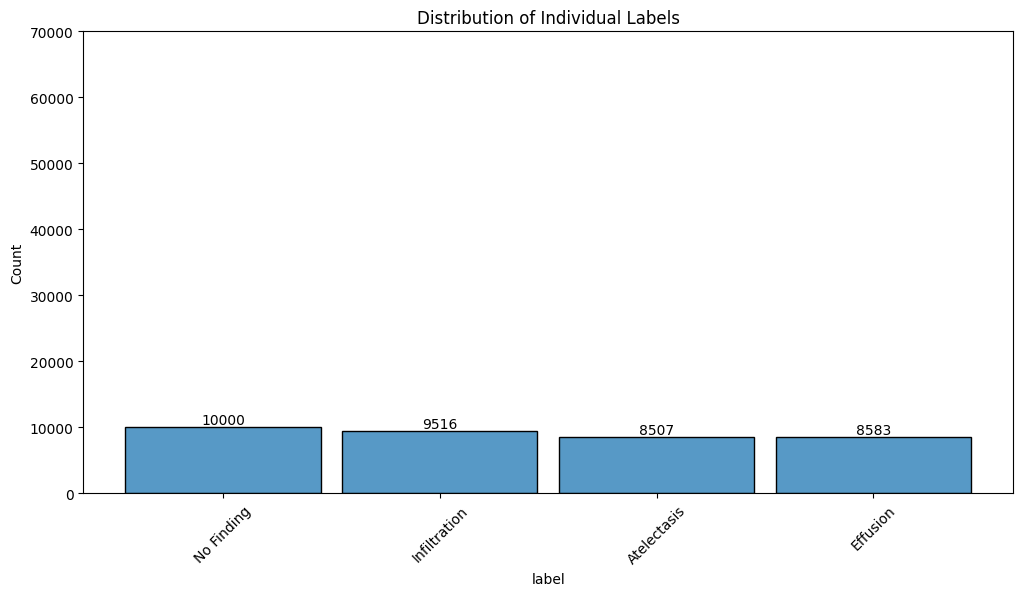

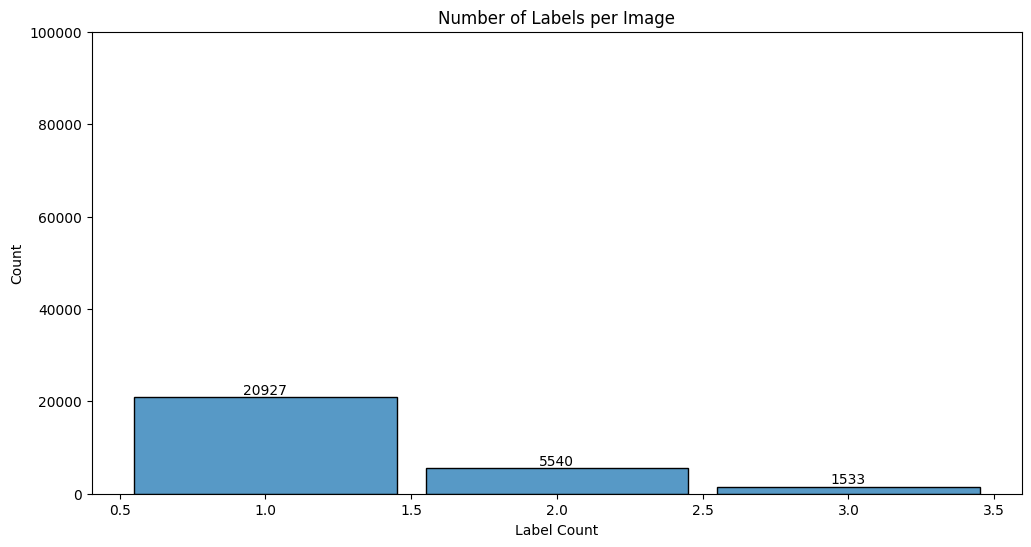

In [16]:
# Splitting labels and counting occurrences
label_counts = df.assign(
    var1=df['Finding Labels'].str.split('|')).explode('var1')["var1"]
label_counts = label_counts.reset_index(drop=True).to_frame()
label_counts.columns = ["label"]

fig, ax = plt.subplots(figsize=(12, 6))
ax.tick_params(axis='x', rotation=45)
sns.histplot(
    label_counts, x="label", discrete=True, ax=ax, shrink=.9).set_title(
        "Distribution of Individual Labels")
ax.bar_label(ax.containers[0])
plt.ylim(0, 70000)
plt.show()

# Analyzing the number of labels per image
labels_per_image = df["Finding Labels"].str.count(r'\|') + 1
labels_per_image = labels_per_image.reset_index(drop=True).to_frame()
labels_per_image.columns = ["Label Count"]

fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    labels_per_image,
    x="Label Count",
    discrete=True,
    ax=ax,
    shrink=.9).set_title("Number of Labels per Image")
ax.bar_label(ax.containers[0])
plt.ylim(0, 100000)
plt.show()

### Other Features

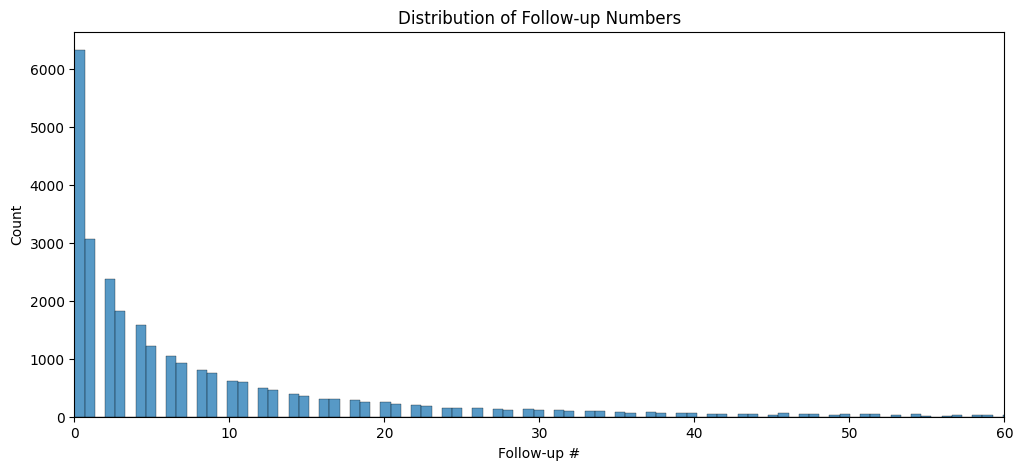

In [17]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=df, x="Follow-up #", ax=ax).set_title(
    'Distribution of Follow-up Numbers')
plt.xlim(0, 60)
plt.show()

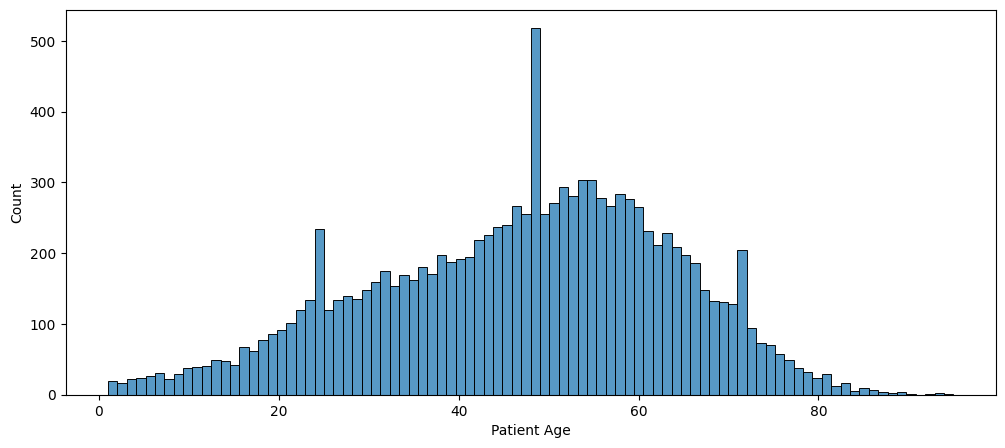

In [18]:
test = df.groupby("Patient ID").agg('first')

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(test, x="Patient Age", ax=ax, bins=90)
plt.show()

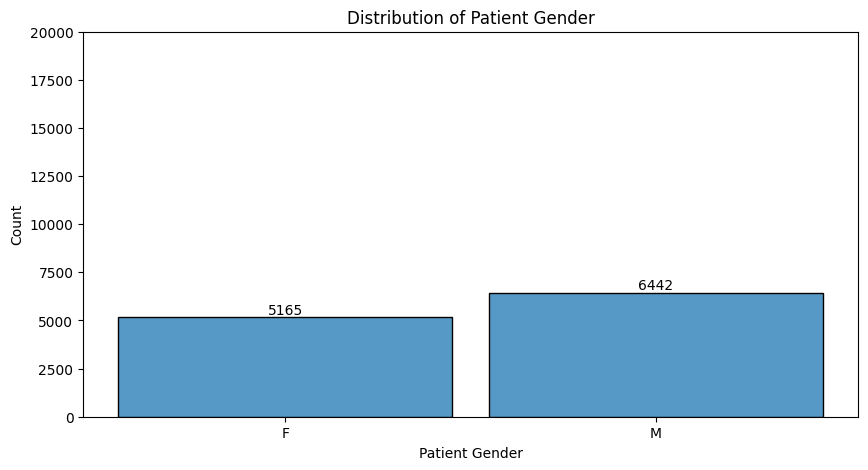

In [19]:
test = df.groupby("Patient ID").agg('first')

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(
    test,
    x="Patient Gender",
    discrete=True,
    ax=ax,
    shrink=.9).set_title("Distribution of Patient Gender")
ax.bar_label(ax.containers[0])
plt.ylim(0, 20000)
plt.show()

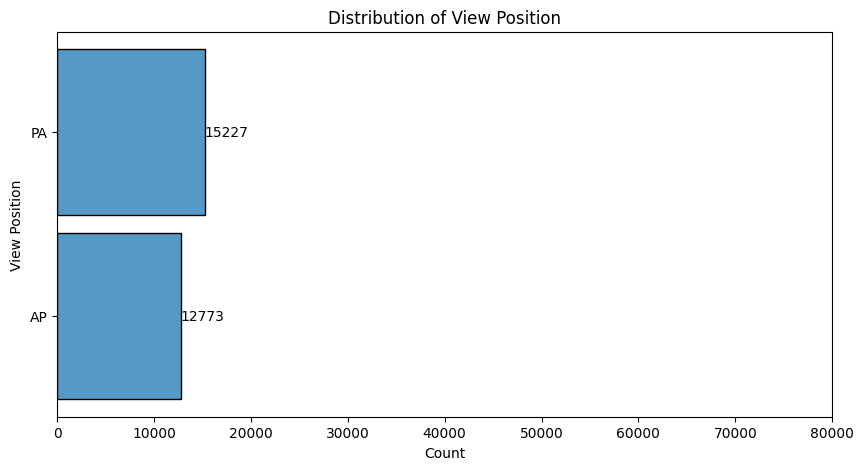

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(
    df, y='View Position', discrete=True, ax=ax, shrink=.9).set_title(
        "Distribution of View Position")
ax.bar_label(ax.containers[0])
plt.xlim(0, 80000)
plt.show()

## Feature relationships

In [21]:
cols_of_interest = [
    "Image Index", "Finding Labels", "Follow-up #", "Patient ID",
    "Patient Age", "Patient Gender", "View Position", 'Image Path'
]

df = df[cols_of_interest]

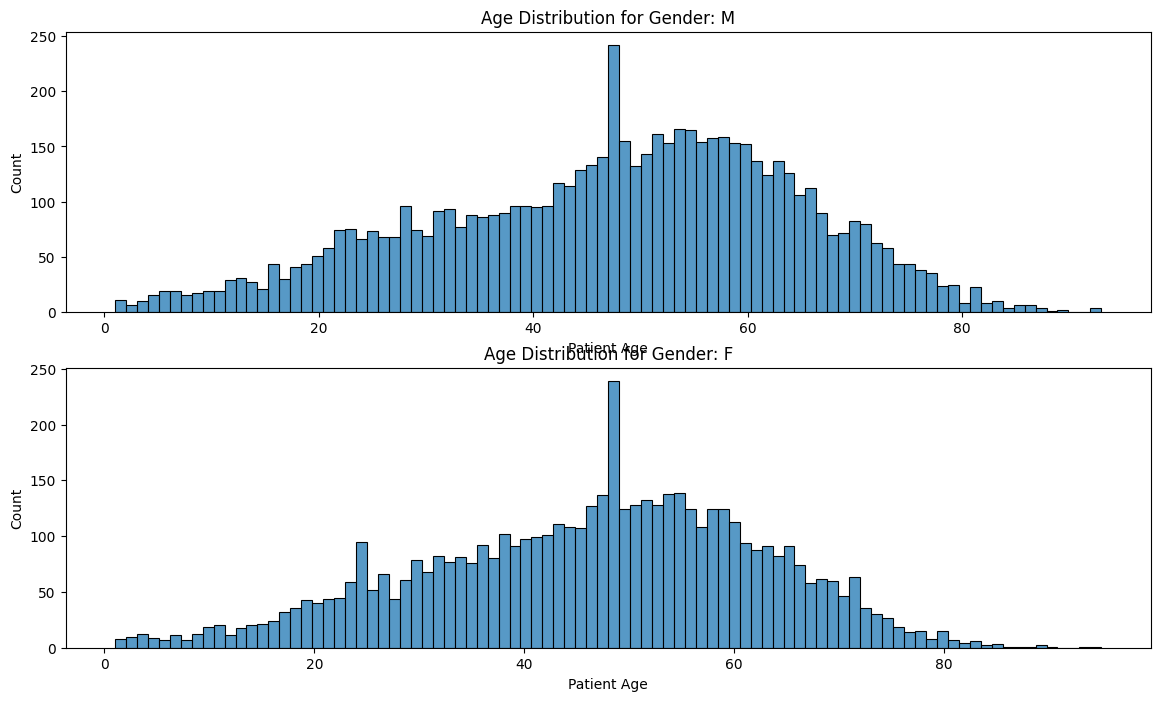

In [22]:
test = df.groupby("Patient ID").agg('first')
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

for i, val in enumerate(["M", "F"]):
    test1 = test[test['Patient Gender'] == val].reset_index()
    sns.histplot(test1, x="Patient Age", ax=axes[i], bins=90)
    axes[i].set_title(f"Age Distribution for Gender: {val}")

plt.show()

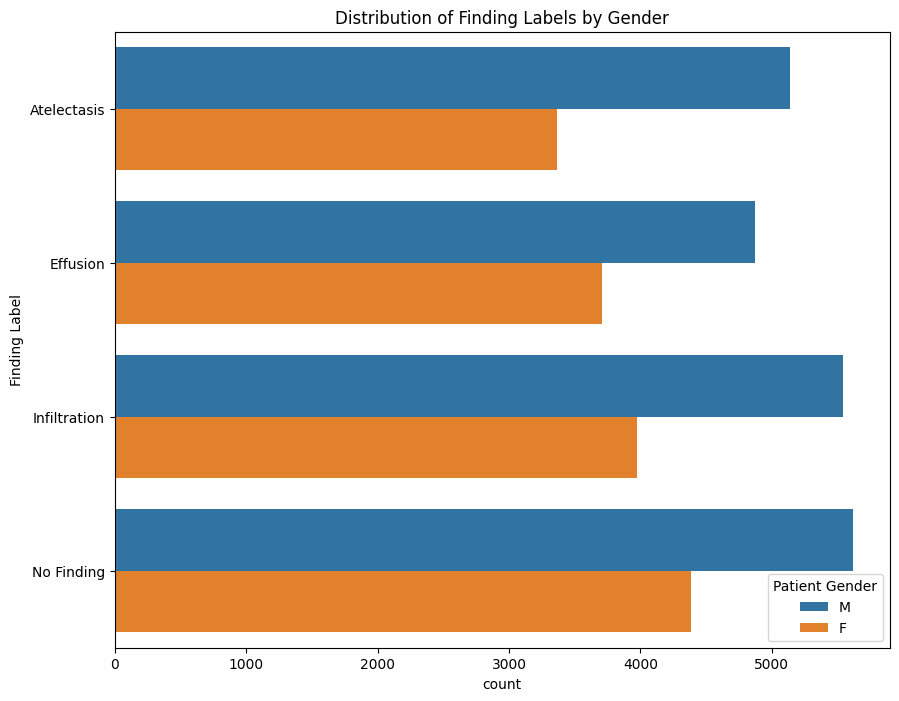

In [23]:
test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')
plot_df = pd.DataFrame()

for val in ["M", "F"]:
    test1 = test[test["Patient Gender"] == val].reset_index(drop=True)
    test1 = test1.groupby("var1").size().sort_index().reset_index(
        name="count")
    test1["Patient Gender"] = val

    plot_df = pd.concat([plot_df, test1]).reset_index(drop=True)

plt.figure(figsize=(10, 8))
plt.title("Distribution of Finding Labels by Gender")
ax = sns.barplot(
    y="var1", hue="Patient Gender", x="count", data=plot_df, orient='h')
plt.ylabel("Finding Label")
plt.show()

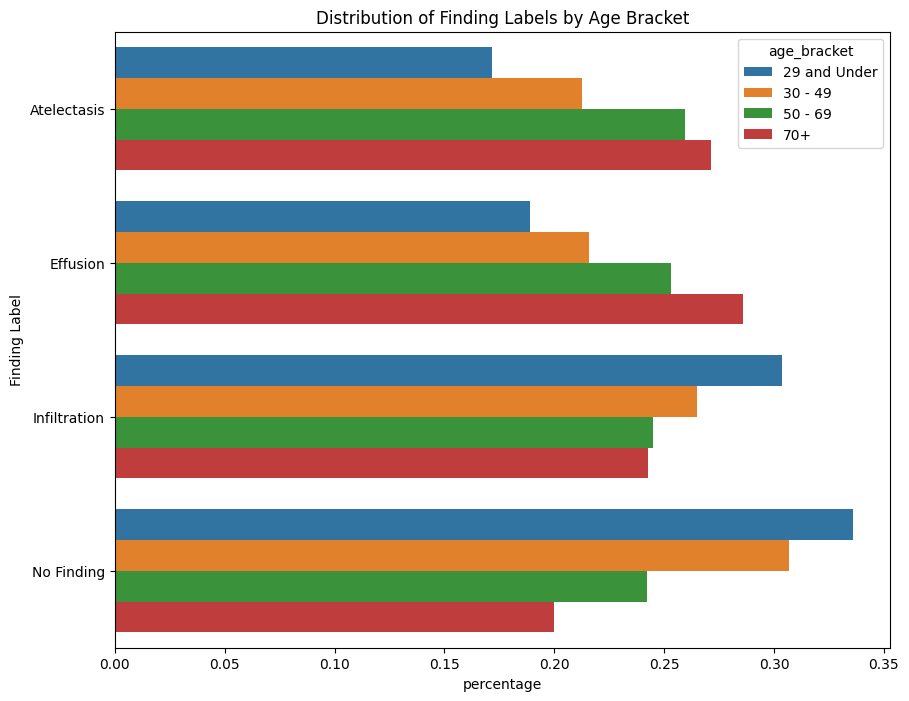

In [24]:
test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')

conditions = [
    (test['Patient Age'] <= 29),
    (test['Patient Age'] >= 30) & (test['Patient Age'] <= 49),
    (test['Patient Age'] >= 50) & (test['Patient Age'] <= 69),
    (test['Patient Age'] >= 70)
]

choices = ['29 and Under', '30 - 49', '50 - 69', '70+']
test['age_bracket'] = np.select(conditions, choices, default=np.nan)
test1 = test.groupby(
    ["age_bracket", "var1"]).size().sort_index().reset_index(name="count")
test2 = test1.groupby("age_bracket").sum("count").reset_index()

test1 = test1.merge(test2, on='age_bracket', suffixes=('', '_total'))
test1["percentage"] = test1["count"] / test1["count_total"]

plt.figure(figsize=(10, 8))
plt.title("Distribution of Finding Labels by Age Bracket")
ax = sns.barplot(
    y="var1",
    hue="age_bracket",
    x="percentage",
    data=test1,
    orient='h')
plt.ylabel("Finding Label")
plt.show()

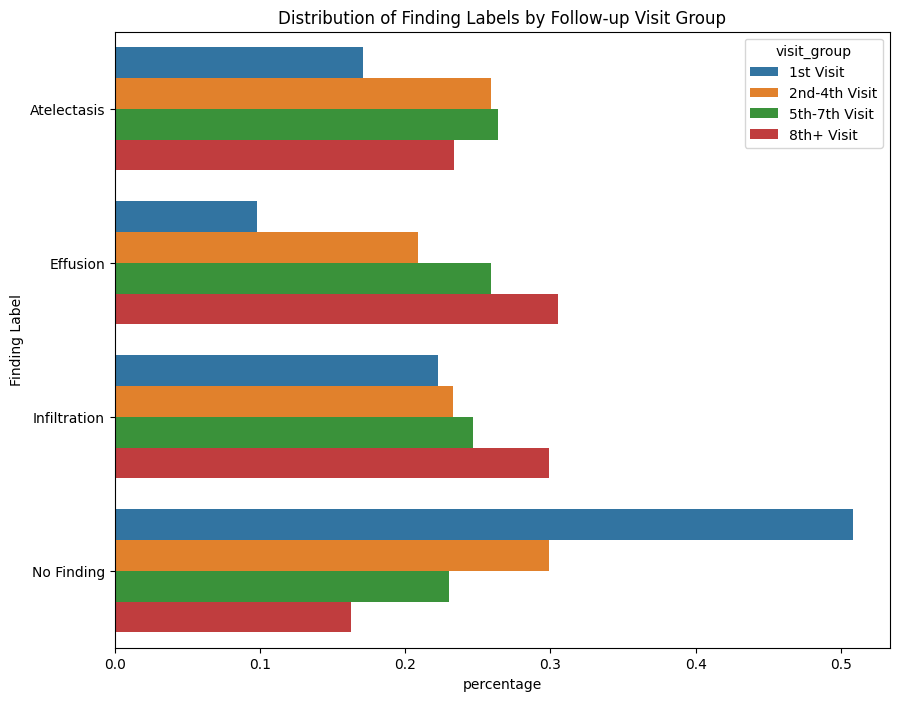

In [25]:
test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')

conditions = [
    (test['Follow-up #'] == 0),  # First visit
    (test['Follow-up #'] >= 1) & (test['Follow-up #'] <= 3),
    (test['Follow-up #'] >= 4) & (test['Follow-up #'] <= 6),
    (test['Follow-up #'] >= 7)
]

choices = ['1st Visit', '2nd-4th Visit', '5th-7th Visit', '8th+ Visit']
test['visit_group'] = np.select(conditions, choices, default=np.nan)
test1 = test.groupby(
    ["visit_group", "var1"]).size().sort_index().reset_index(name="count")
test2 = test1.groupby("visit_group").sum("count").reset_index()

test1 = test1.merge(test2, on='visit_group', suffixes=('', '_total'))
test1["percentage"] = test1["count"] / test1["count_total"]

plt.figure(figsize=(10, 8))
plt.title("Distribution of Finding Labels by Follow-up Visit Group")
ax = sns.barplot(
    y="var1", hue="visit_group", x="percentage", data=test1, orient='h')
plt.ylabel("Finding Label")
plt.show()

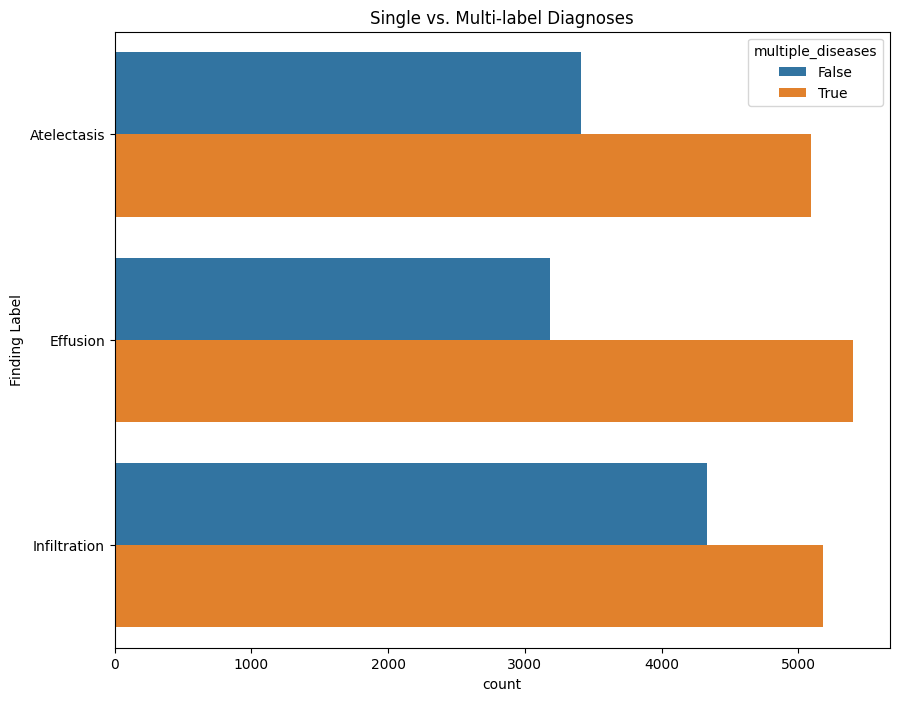

In [26]:
test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')
test["multiple_diseases"] = test[
    'Finding Labels'].str.match(r'\w+\|\w+')  # Identifying multi-label cases
test = test[test["Finding Labels"] != "No Finding"]
test1 = test.groupby(
    ["var1",
        "multiple_diseases"]).size().sort_index().reset_index(name="count")

plt.figure(figsize=(10, 8))
plt.title("Single vs. Multi-label Diagnoses")
ax = sns.barplot(
    y="var1", hue="multiple_diseases", x="count", data=test1, orient='h')
plt.ylabel("Finding Label")
plt.show()

<ipython-input-27-8fa5733ecea8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["tags"] = df_filtered["Finding Labels"].str.split("|")
<ipython-input-27-8fa5733ecea8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["tags"] = df_filtered["tags"].apply(lambda x: sorted(x))


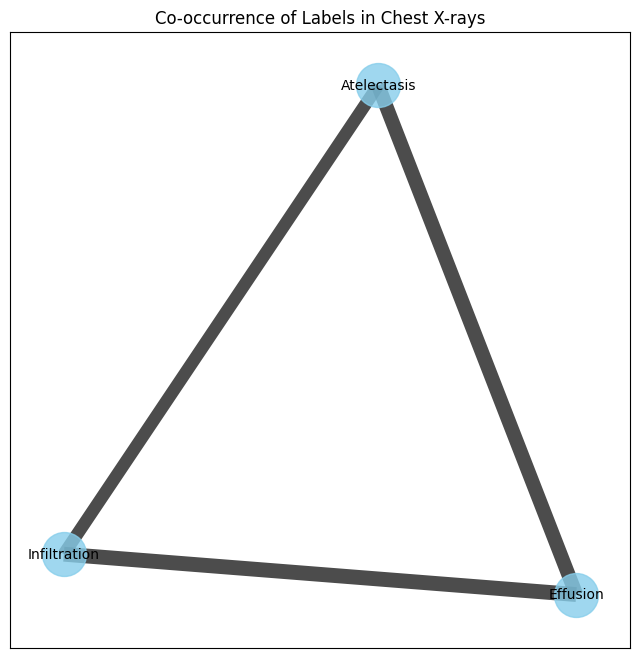

In [27]:
# Preprocessing: Filtering for images with exactly two labels
df_filtered = df[df["Finding Labels"].str.count(r'\|') == 1]
df_filtered["tags"] = df_filtered["Finding Labels"].str.split("|")
df_filtered["tags"] = df_filtered["tags"].apply(lambda x: sorted(x))

# Getting unique labels
all_tags = np.unique(np.concatenate(df_filtered['tags'].values))

# Helper function to add edge weight
def add_edge_weight(head, tail, graph):
    try:
        graph[head][tail]['weight'] += 1
    except:
        graph.add_edge(head, tail, weight=1)

# Initializing the graph
G = nx.Graph()

# Adding nodes (tags)
for t in all_tags:
    G.add_node(t)

# Adding edges (co-occurring tags)
for _, row in df_filtered.iterrows():
    tags = row['tags']
    add_edge_weight(tags[0], tags[1], G)

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, k=1.5)  # Adjust k for spacing

# Calculating total edge weights
w_sum = sum([data['weight'] for (_, _, data) in G.edges(data=True)])

# Drawing edges with varying width based on weight
for (node1, node2, data) in G.edges(data=True):
    width = data["weight"] * len(G.nodes) * 10.0 / w_sum
    nx.draw_networkx_edges(
        G, pos, edgelist=[(node1, node2)], width=width, alpha=0.7)

nx.draw_networkx_nodes(
    G, pos, node_size=1000, node_color='skyblue', alpha=0.8)

# Drawing labels without overlap
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
plt.title("Co-occurrence of Labels in Chest X-rays")
plt.show()

## Visualizing images with bounding boxes

        Image Index Finding Label     Bbox [x           y          w  \
0  00013118_008.png   Atelectasis  225.084746  547.019217  86.779661   

          h]  Unnamed: 6  Unnamed: 7  Unnamed: 8  
0  79.186441         NaN         NaN         NaN  


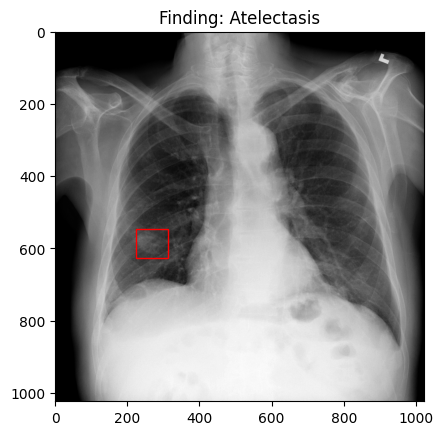

In [28]:
bbox_df = pd.read_csv(drive_path + "BBox_List_2017.csv")

print(bbox_df.head(1))
# Load the first image from dataframe
image_path = drive_path + "images_006/images/" + bbox_df['Image Index'][0]
image = Image.open(image_path)
x = bbox_df['Bbox [x'][0]
y = bbox_df['y'][0]
w = bbox_df['w'][0]
h = bbox_df['h]'][0]

fig, ax = plt.subplots(1)
ax.imshow(image, cmap='gray')

# Create rectangle
rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the img
ax.add_patch(rect)

plt.title(f"Finding: {bbox_df['Finding Label'][0]}")
plt.show()

## Target One Hot Encoding

In [29]:
# create list of targets
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

In [30]:
mlb = MultiLabelBinarizer()

ohe_target = mlb.fit_transform(df['Finding Labels'])
ohe_df = pd.DataFrame(ohe_target, columns=mlb.classes_)

target_cols = ohe_df.columns.to_list()

In [31]:
df = pd.concat([df, ohe_df], axis=1)
df.drop(columns='Finding Labels', inplace=True)
# df.columns = df.columns.str.replace(' ', '_')

df.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Image Path,Atelectasis,Effusion,Infiltration,No Finding
0,00010432_000.png,0,10432,50,F,PA,/content/drive/MyDrive/AAI-590 Capstone/images...,0,0,0,1
1,00012028_001.png,1,12028,68,F,AP,/content/drive/MyDrive/AAI-590 Capstone/images...,0,0,1,0
2,00024108_000.png,0,24108,22,M,PA,/content/drive/MyDrive/AAI-590 Capstone/images...,0,0,0,1
3,00008522_038.png,38,8522,61,F,AP,/content/drive/MyDrive/AAI-590 Capstone/images...,0,0,0,1
4,00030139_001.png,1,30139,37,M,PA,/content/drive/MyDrive/AAI-590 Capstone/images...,0,0,0,1


## Feature Label Encoding

In [32]:
le_gender = LabelEncoder()
le_view_position = LabelEncoder()

df['Patient Gender'] = le_gender.fit_transform(df['Patient Gender'])
df['View Position'] = le_view_position.fit_transform(df['View Position'])

In [33]:
df.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Image Path,Atelectasis,Effusion,Infiltration,No Finding
0,00010432_000.png,0,10432,50,0,1,/content/drive/MyDrive/AAI-590 Capstone/images...,0,0,0,1
1,00012028_001.png,1,12028,68,0,0,/content/drive/MyDrive/AAI-590 Capstone/images...,0,0,1,0
2,00024108_000.png,0,24108,22,1,1,/content/drive/MyDrive/AAI-590 Capstone/images...,0,0,0,1
3,00008522_038.png,38,8522,61,0,0,/content/drive/MyDrive/AAI-590 Capstone/images...,0,0,0,1
4,00030139_001.png,1,30139,37,1,1,/content/drive/MyDrive/AAI-590 Capstone/images...,0,0,0,1


In [34]:
df.to_csv(drive_path + 'final_dataset.csv')

# Modeling Prep - Train Test Split

In [35]:
df.columns

Index(['Image Index', 'Follow-up #', 'Patient ID', 'Patient Age',
       'Patient Gender', 'View Position', 'Image Path', 'Atelectasis',
       'Effusion', 'Infiltration', 'No Finding'],
      dtype='object')

In [36]:
df = pd.read_csv(drive_path + 'final_dataset.csv')
# df = df.drop(columns=['Unnamed: 0', 'Follow-up #', 'Patient Age', 'Patient Gender'])

In [37]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=1997)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=1997)

print(f'Training size: {len(train_df)}')
print(f'Validation size: {len(val_df)}')
print(f'Testing size: {len(test_df)}')

Training size: 22400
Validation size: 2800
Testing size: 2800


## Creating Datasets

In [38]:
import tensorflow as tf

IMG_HEIGHT = 300
IMG_WIDTH = 300
CHANNELS = 1

def random_brightness(image):
    return tf.image.random_brightness(image, max_delta=0.1)

# Updated data augmentation using the latest tf.keras.layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.005),
    tf.keras.layers.RandomContrast(0.005),
    tf.keras.layers.RandomTranslation(0.005, 0.005),
    tf.keras.layers.RandomZoom(0.005)  # Added zoom for slight magnification changes
])

def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = data_augmentation(image)
    return image

def image_label_pairs(dataframe):
    image_paths = dataframe['Image Path'].values
    labels = dataframe.iloc[:, -4:].values
    return image_paths, labels


In [39]:
train_image_paths, train_labels = image_label_pairs(train_df)
val_image_paths, val_labels = image_label_pairs(val_df)
test_image_paths, test_labels = image_label_pairs(test_df)

In [40]:
def create_dataset(image_paths, labels, batch_size, shuffle=True, cache=True):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    image_ds = path_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.float32))
    dataset = tf.data.Dataset.zip((image_ds, label_ds))

    if cache:
        dataset = dataset.cache()

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [41]:
df.columns

Index(['Unnamed: 0', 'Image Index', 'Follow-up #', 'Patient ID', 'Patient Age',
       'Patient Gender', 'View Position', 'Image Path', 'Atelectasis',
       'Effusion', 'Infiltration', 'No Finding'],
      dtype='object')

In [42]:
batch_size = 20
train_dataset = create_dataset(train_image_paths, train_labels, batch_size)
val_dataset = create_dataset(val_image_paths, val_labels, batch_size, shuffle=False)
test_dataset = create_dataset(test_image_paths, test_labels, batch_size, shuffle=False)

# Custom CNN

In [43]:
# verify GPU availability
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available.")

GPU is available.


**No Regularization**

In [44]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [46]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

In [47]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 987s 85ms/step - accuracy: 0.3647 - loss: 0.6297 - val_accuracy: 0.4314 - val_loss: 0.5985
Epoch 2/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.4018 - loss: 0.5799 - val_accuracy: 0.4543 - val_loss: 0.5782
Epoch 3/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.4298 - loss: 0.5609 - val_accuracy: 0.4621 - val_loss: 0.5656
Epoch 4/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.4781 - loss: 0.5295 - val_accuracy: 0.4307 - val_loss: 0.5782
Epoch 5/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.5435 - loss: 0.4652 - val_accuracy: 0.4646 - val_loss: 0.5929
Epoch 6/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.6511 - loss: 0.3503 - val_accuracy: 0.4150 - val_loss: 0.7230
Epoch 7/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.7699 - loss: 0.1958 - val_accuracy: 0.4093 - val_loss: 0.9848
Epoch 8/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.8477 

In [48]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

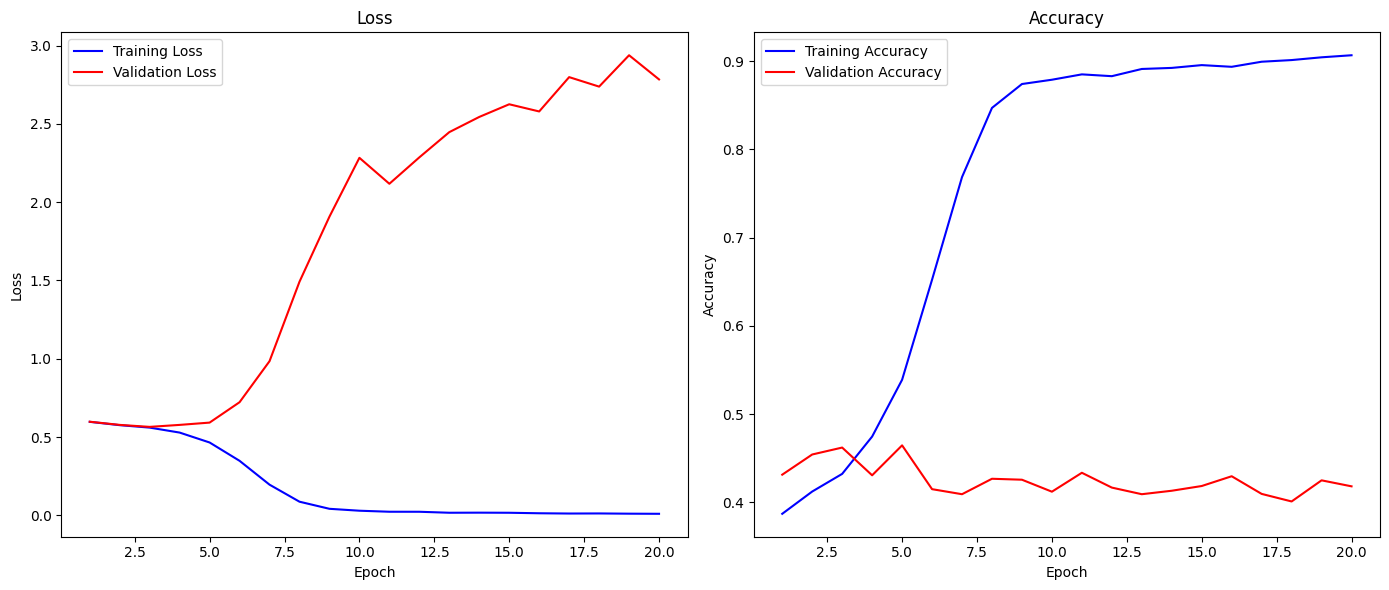

In [49]:
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Dropout Regularization**

In [50]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout layer
    Dense(4, activation='sigmoid')
])

In [51]:
# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [52]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.3401 - loss: 0.7427 - val_accuracy: 0.3536 - val_loss: 0.5998
Epoch 2/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.4013 - loss: 0.5900 - val_accuracy: 0.2968 - val_loss: 0.6096
Epoch 3/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.4006 - loss: 0.5849 - val_accuracy: 0.4196 - val_loss: 0.5842
Epoch 4/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.4076 - loss: 0.5801 - val_accuracy: 0.4293 - val_loss: 0.5802
Epoch 5/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.4270 - loss: 0.5724 - val_accuracy: 0.4489 - val_loss: 0.5741
Epoch 6/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.4252 - loss: 0.5670 - val_accuracy: 0.4107 - val_loss: 0.5806
Epoch 7/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.4412 - loss: 0.5551 - val_accuracy: 0.4182 - val_loss: 0.5892
Epoch 8/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.4606 -

In [53]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

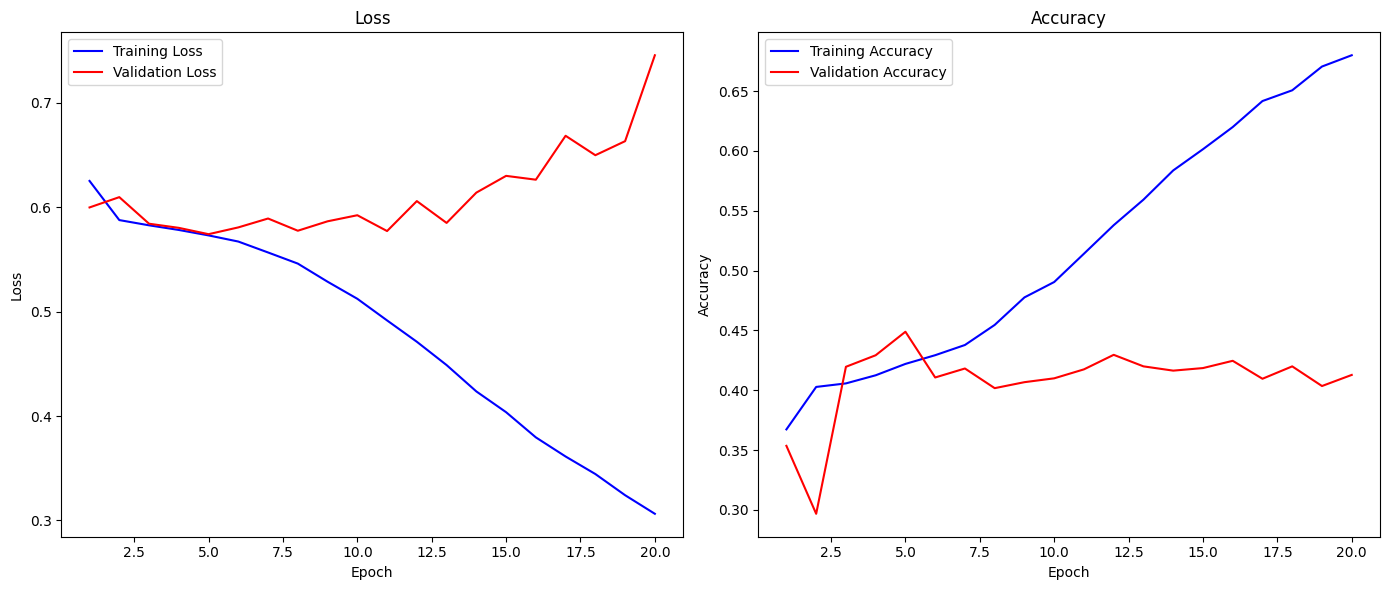

In [54]:
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**L2 Regularization**

In [55]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(4, activation='sigmoid')
])

In [56]:
# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [57]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.3025 - loss: 1.1406 - val_accuracy: 0.3504 - val_loss: 0.6359
Epoch 2/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.3434 - loss: 0.6301 - val_accuracy: 0.3504 - val_loss: 0.6346
Epoch 3/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.3174 - loss: 0.6301 - val_accuracy: 0.3504 - val_loss: 0.6345
Epoch 4/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.3279 - loss: 0.6302 - val_accuracy: 0.3504 - val_loss: 0.6343
Epoch 5/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.3276 - loss: 0.6302 - val_accuracy: 0.3504 - val_loss: 0.6342
Epoch 6/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.3437 - loss: 0.6303 - val_accuracy: 0.1532 - val_loss: 0.6341
Epoch 7/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.3089 - loss: 0.6315 - val_accuracy: 0.1532 - val_loss: 0.6343
Epoch 8/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.2949 -

In [58]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

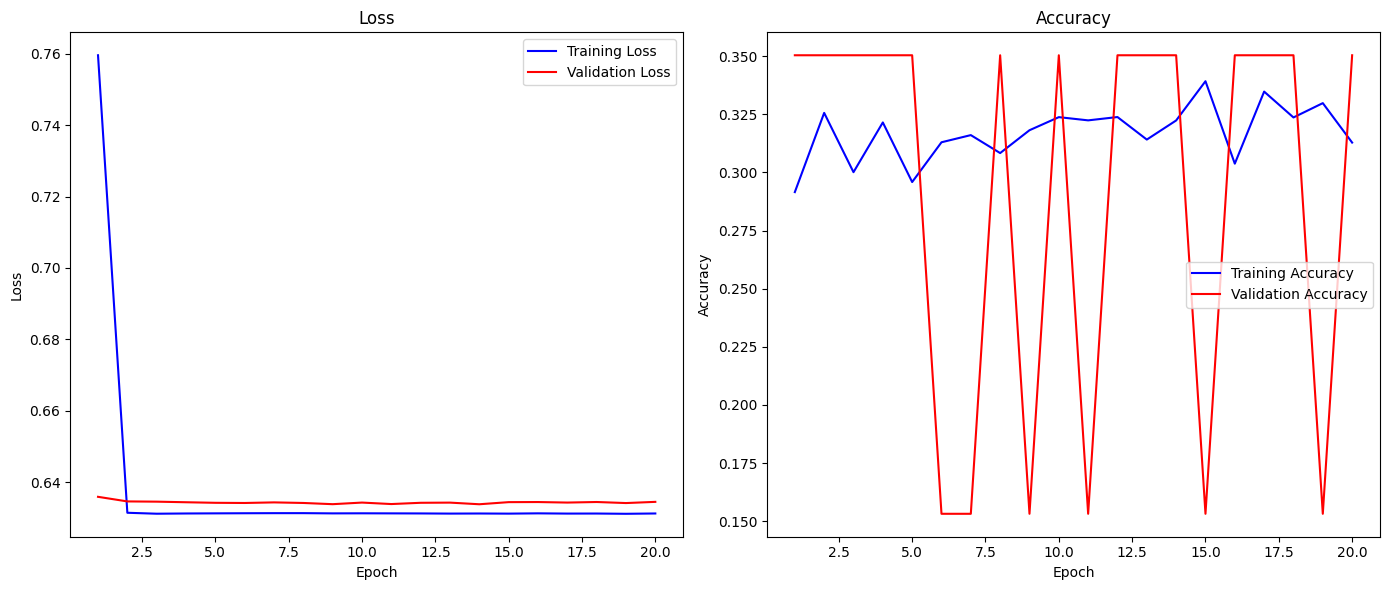

In [59]:
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Weaker L2 Regularization**

In [60]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(4, activation='sigmoid')
])

In [61]:
# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [62]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.3478 - loss: 0.7615 - val_accuracy: 0.3811 - val_loss: 0.6393
Epoch 2/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.3772 - loss: 0.6184 - val_accuracy: 0.3343 - val_loss: 0.6161
Epoch 3/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.3696 - loss: 0.6080 - val_accuracy: 0.2779 - val_loss: 0.6209
Epoch 4/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.3756 - loss: 0.6021 - val_accuracy: 0.3675 - val_loss: 0.6023
Epoch 5/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.3764 - loss: 0.5990 - val_accuracy: 0.3811 - val_loss: 0.6019
Epoch 6/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.3840 - loss: 0.5965 - val_accuracy: 0.3814 - val_loss: 0.6016
Epoch 7/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.3804 - loss: 0.5960 - val_accuracy: 0.3664 - val_loss: 0.5979
Epoch 8/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.3842 -

In [63]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

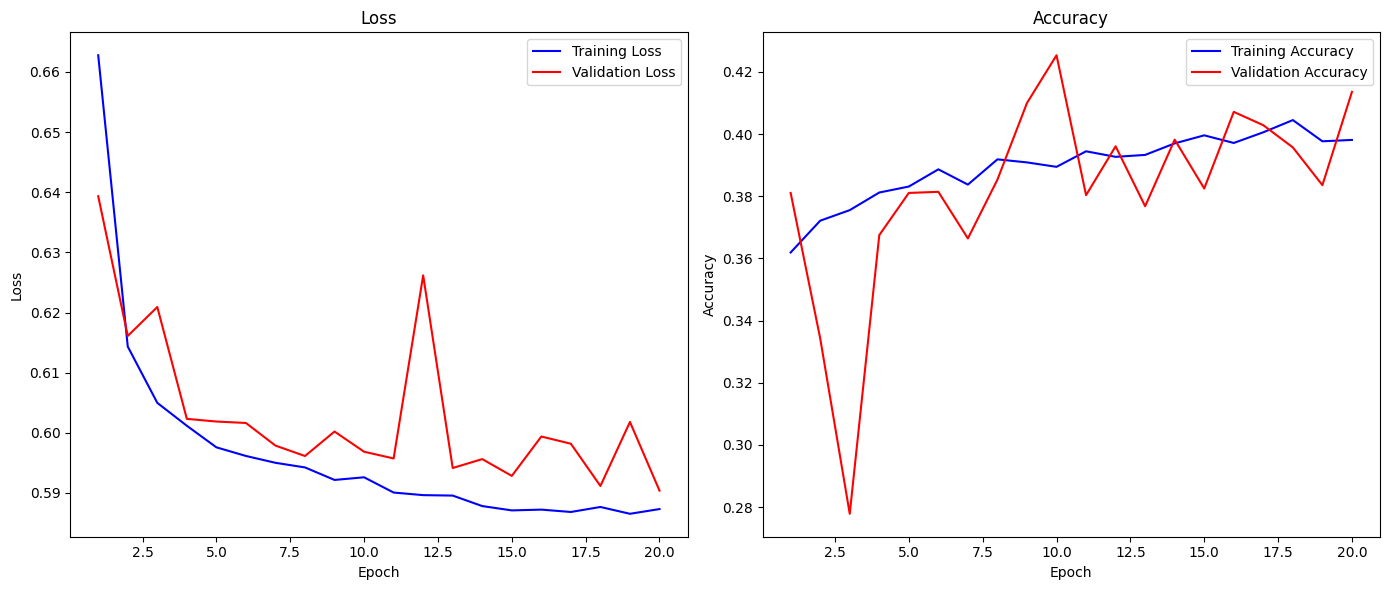

In [64]:
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Increasing Model Complexity**

In [65]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),  # Additional layer
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),  # Additional dense layer
    Dense(4, activation='sigmoid')
])

In [66]:
# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [67]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.3307 - loss: 0.6180 - val_accuracy: 0.3882 - val_loss: 0.5900
Epoch 2/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.4050 - loss: 0.5847 - val_accuracy: 0.4104 - val_loss: 0.5856
Epoch 3/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.4263 - loss: 0.5732 - val_accuracy: 0.4368 - val_loss: 0.5732
Epoch 4/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.4401 - loss: 0.5598 - val_accuracy: 0.4254 - val_loss: 0.5668
Epoch 5/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.4673 - loss: 0.5458 - val_accuracy: 0.4729 - val_loss: 0.5676
Epoch 6/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.4771 - loss: 0.5299 - val_accuracy: 0.4586 - val_loss: 0.5616
Epoch 7/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.5092 - loss: 0.5043 - val_accuracy: 0.4457 - val_loss: 0.5702
Epoch 8/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.5360 -

In [68]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy}')

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.append(labels.numpy())
    predictions = model.predict(images)
    y_pred.append(predictions)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Convert predictions to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

# Generate the classification report
report = classification_report(y_true, y_pred_binary, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
print(report)

140/140 ━━━━━━━━━━━━━━━━━━━━ 74s 527ms/step - accuracy: 0.4389 - loss: 1.9180
Test Accuracy: 0.41285714507102966
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

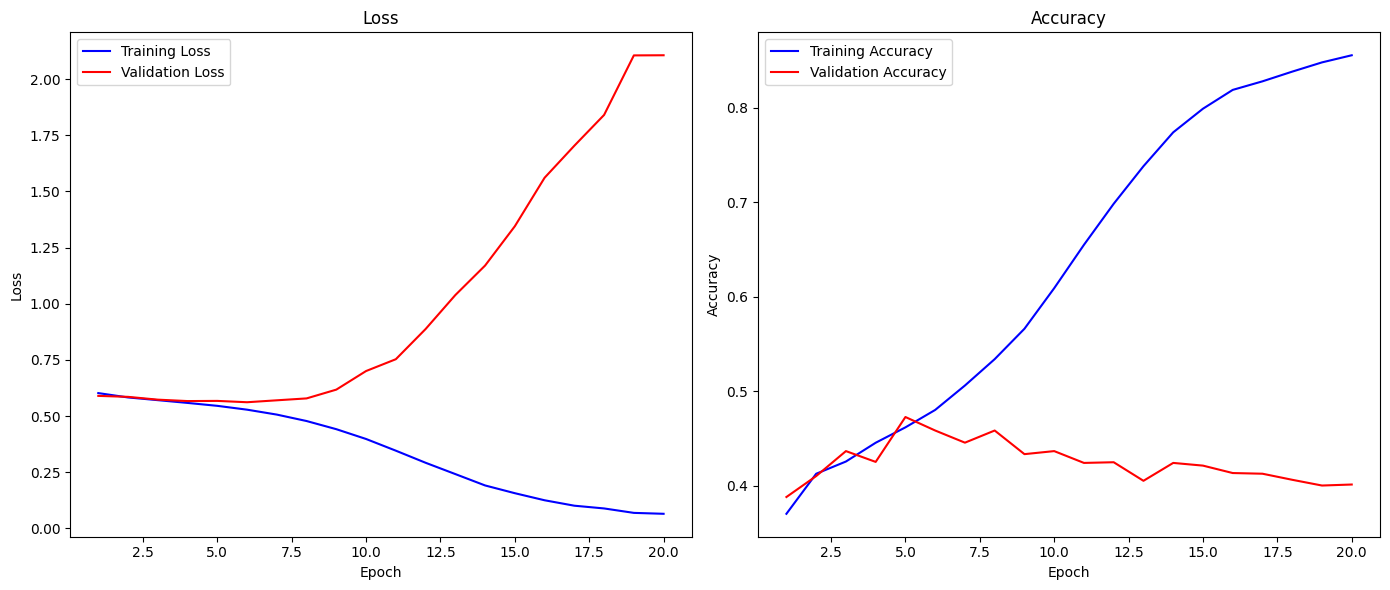

In [70]:
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Adding Dropout + Addtional Complexity**

In [71]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(.5),

    Dense(4, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [72]:
# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [73]:
# Define the learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.001)

In [74]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 49s 29ms/step - accuracy: 0.3212 - loss: 0.7655 - val_accuracy: 0.3943 - val_loss: 0.5943 - learning_rate: 0.0010
Epoch 2/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.3909 - loss: 0.5966 - val_accuracy: 0.3504 - val_loss: 0.8830 - learning_rate: 0.0010
Epoch 3/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.4064 - loss: 0.5845 - val_accuracy: 0.4321 - val_loss: 0.5856 - learning_rate: 0.0010
Epoch 4/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.4043 - loss: 0.5835 - val_accuracy: 0.4182 - val_loss: 0.5935 - learning_rate: 0.0010
Epoch 5/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.4125 - loss: 0.5821 - val_accuracy: 0.4182 - val_loss: 0.5905 - learning_rate: 0.0010
Epoch 6/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.3967 - loss: 0.5921 - val_accuracy: 0.4179 - val_loss: 0.5834 - learning_rate: 0.0010
Epoch 7/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accura

In [75]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [76]:
from tensorflow.keras.models import save_model
model.save('best_model_complete.keras')

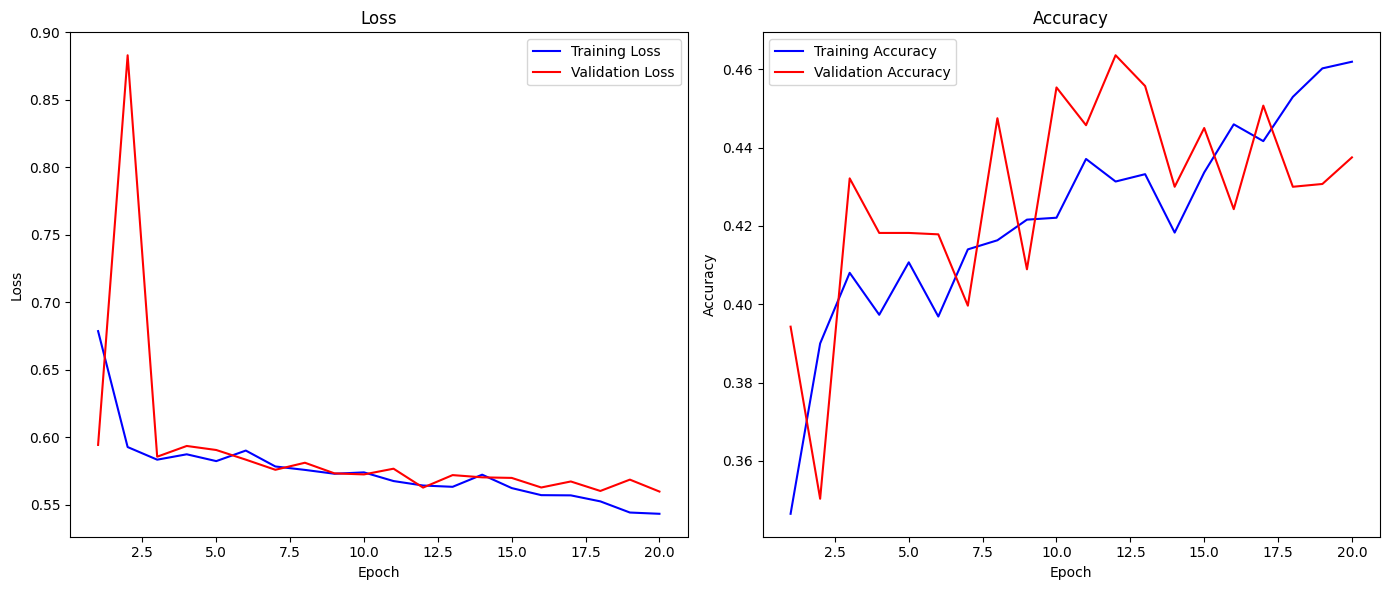

In [77]:
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [78]:
# Load the entire model
model = tf.keras.models.load_model('best_model.keras')

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on the test dataset
y_pred = model.predict(test_dataset)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Binarize predictions
y_pred_binary = (y_pred > 0.3).astype(int)

# Generate classification report
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_true, y_pred_binary, target_names=['No Finding', 'Infiltration', 'Effusion', 'Atelectasis']))

# Calculate AUC-ROC for each class
auc_roc = roc_auc_score(y_true, y_pred, average=None)
for i, label in enumerate(['No Finding', 'Infiltration', 'Effusion', 'Atelectasis']):
    print(f"{label}: AUC-ROC = {auc_roc[i]:.4f}")

# Calculate macro and micro average AUC-ROC
macro_auc_roc = roc_auc_score(y_true, y_pred, average='macro')
micro_auc_roc = roc_auc_score(y_true, y_pred, average='micro')
print(f"Macro AUC-ROC: {macro_auc_roc:.4f}")
print(f"Micro AUC-ROC: {micro_auc_roc:.4f}")

140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4646 - loss: 0.5435
Test Loss: 0.552668035030365
Test Accuracy: 0.4399999976158142
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

  No Finding       0.44      0.70      0.54       856
Infiltration       0.49      0.80      0.61       853
    Effusion       0.38      0.74      0.50       893
 Atelectasis       0.53      0.75      0.62      1037

   micro avg       0.46      0.75      0.57      3639
   macro avg       0.46      0.75      0.57      3639
weighted avg       0.46      0.75      0.57      3639
 samples avg       0.47      0.73      0.55      3639

No Finding: AUC-ROC = 0.7196
Infiltration: AUC-ROC = 0.7932
Effusion: AUC-ROC = 0.6572
Atelectasis: AUC-ROC = 0.7399
Macro AUC-ROC: 0.7275
Micro AUC-ROC: 0.7330


## Keras-Tuner

In [81]:
# Define the model building function
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv1_units', min_value=32, max_value=64, step=32),
                     (3, 3),
                     activation=hp.Choice('activation', values=['relu', 'leaky_relu']),
                     input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)))

    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(Conv2D(hp.Int(f'conv{i+2}_units', min_value=32, max_value=64, step=32),
                         (3, 3),
                         activation=hp.Choice('activation', values=['relu', 'leaky_relu'])))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(hp.Float(f'dropout_conv{i+2}', 0.2, 0.5, step=0.1)))

    model.add(Flatten())

    for i in range(hp.Int('num_dense_layers', 1, 2)):
        model.add(Dense(hp.Int(f'dense{i+1}_units', min_value=128, max_value=256, step=128),
                        activation=hp.Choice('activation', values=['relu', 'leaky_relu'])))
        model.add(Dropout(hp.Float(f'dropout_dense{i+1}', 0.2, 0.5, step=0.1)))

    model.add(Dense(4, activation='sigmoid'))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

# Instantiate the tuner with RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory='my_dir',
    project_name='chest_xray_classification',
    distribution_strategy=tf.distribute.MirroredStrategy()  # Parallelize the search
)

# Display a summary of the search space
tuner.search_space_summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('tuned_model.keras', save_best_only=True, monitor='val_loss')

# Perform the hyperparameter search
tuner.search(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping, model_checkpoint])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first convolutional layer is {best_hps.get('conv1_units')},
the optimal number of convolutional layers is {best_hps.get('num_conv_layers')},
the optimal number of units in the dense layers is {best_hps.get('dense1_units')},
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 10 Complete [00h 05m 39s]
val_loss: 0.6570478081703186

Best val_loss So Far: 0.5676957964897156
Total elapsed time: 01h 22m 26s

The hyperparameter search is complete. The optimal number of units in the first convolutional layer is 32,
the optimal number of convolutional layers is 3,
the optimal number of units in the dense layers is 128,
and the optimal learning rate for the optimizer is 0.001.



In [90]:
# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[early_stopping, model_checkpoint]
)

# Load the best model
model.load_weights('tuned_model.keras')

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on the test dataset
y_pred = model.predict(test_dataset)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

y_pred_binary = (y_pred > 0.3).astype(int)

# Generate classification report
print(classification_report(y_true, y_pred_binary, target_names=target_cols))

# Calculate AUC-ROC for each class
auc_roc = roc_auc_score(y_true, y_pred, average=None)
for i, label in enumerate(target_cols):
    print(f"{label}: AUC-ROC = {auc_roc[i]:.4f}")

# Calculate macro and micro average AUC-ROC
macro_auc_roc = roc_auc_score(y_true, y_pred, average='macro')
micro_auc_roc = roc_auc_score(y_true, y_pred, average='micro')
print(f"Macro AUC-ROC: {macro_auc_roc:.4f}")
print(f"Micro AUC-ROC: {micro_auc_roc:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.3299 - loss: 0.7322 - val_accuracy: 0.3136 - val_loss: 0.6002
Epoch 2/15
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.3741 - loss: 0.6061 - val_accuracy: 0.4143 - val_loss: 0.5871
Epoch 3/15
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.3998 - loss: 0.5867 - val_accuracy: 0.4371 - val_loss: 0.5827
Epoch 4/15
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.4252 - loss: 0.5729 - val_accuracy: 0.4357 - val_loss: 0.5744
Epoch 5/15
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.4360 - loss: 0.5656 - val_accuracy: 0.4243 - val_loss: 0.5683
Epoch 6/15
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.4464 - loss: 0.5566 - val_accuracy: 0.4686 - val_loss: 0.5725
Epoch 7/15
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.4565 - loss: 0.5491 - val_accuracy: 0.4289 - val_loss: 0.5973
Epoch 8/15
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.4704 -

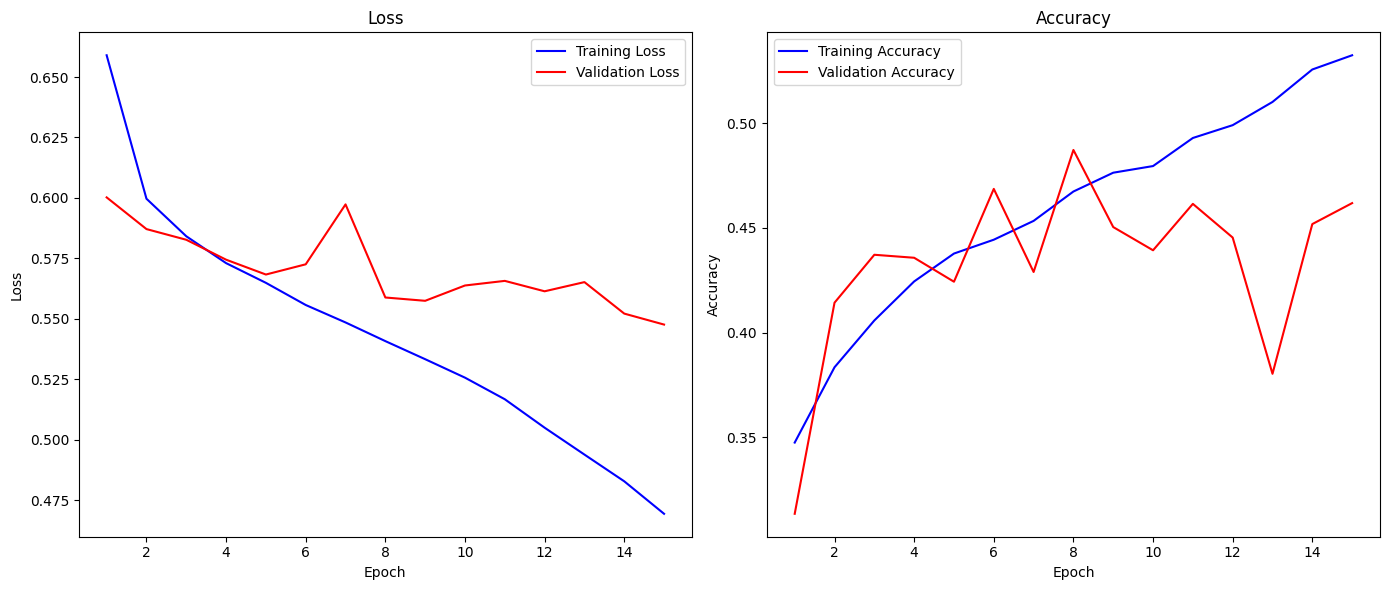

In [99]:
# Plotting the training and validation loss and accuracy
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

##VGG16 Pretrained Model

In [95]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

# Changing the input layer to accept 1-channel (grayscale)
new_input = Input(shape=(300, 300, 1))
x = Conv2D(3, (3, 3), padding='same')(new_input)

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
vgg16_output = vgg16(x)
add_model = Sequential()
add_model.add(Flatten(input_shape=vgg16_output.shape[1:]))
add_model.add(Dropout(0.2))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dropout(0.2))
add_model.add(Dense(4, activation='sigmoid'))

# Create final model
model_vgg16 = Model(inputs=new_input, outputs=add_model(vgg16_output))
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_vgg16.keras', save_best_only=True, monitor='val_loss')

# Train
history_vgg16 = model_vgg16.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 98s 67ms/step - accuracy: 0.2985 - loss: 0.6311 - val_accuracy: 0.4186 - val_loss: 0.5817
Epoch 2/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 72s 64ms/step - accuracy: 0.4214 - loss: 0.5778 - val_accuracy: 0.4421 - val_loss: 0.5513
Epoch 3/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 72s 64ms/step - accuracy: 0.4583 - loss: 0.5462 - val_accuracy: 0.4839 - val_loss: 0.5386
Epoch 4/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 72s 64ms/step - accuracy: 0.4728 - loss: 0.5316 - val_accuracy: 0.4900 - val_loss: 0.5341
Epoch 5/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 72s 64ms/step - accuracy: 0.4905 - loss: 0.5221 - val_accuracy: 0.4739 - val_loss: 0.5295
Epoch 6/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 72s 64ms/step - accuracy: 0.4964 - loss: 0.5124 - val_accuracy: 0.5061 - val_loss: 0.5229
Epoch 7/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 71s 63ms/step - accuracy: 0.5086 - loss: 0.4985 - val_accuracy: 0.5104 - val_loss: 0.5275
Epoch 8/20
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 72s 64ms/step - accuracy: 0.5252 -

In [96]:
# Evaluate the VGG16 model on the test dataset
model_vgg16.load_weights('best_model_vgg16.keras')
test_loss_vgg16, test_accuracy_vgg16 = model_vgg16.evaluate(test_dataset)
print(f"VGG16 Test Loss: {test_loss_vgg16}")
print(f"VGG16 Test Accuracy: {test_accuracy_vgg16}")

# Predict on the test dataset
y_pred_vgg16 = model_vgg16.predict(test_dataset)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_binary_vgg16 = (y_pred_vgg16 > 0.3).astype(int)

# Generate classification report
print(classification_report(y_true, y_pred_binary_vgg16, target_names=['No Finding', 'Infiltration', 'Effusion', 'Atelectasis']))

# Calculate AUC-ROC for each class
auc_roc_vgg16 = roc_auc_score(y_true, y_pred_vgg16, average=None)
for i, label in enumerate(['No Finding', 'Infiltration', 'Effusion', 'Atelectasis']):
    print(f"{label}: AUC-ROC = {auc_roc_vgg16[i]:.4f}")

# Calculate macro and micro average AUC-ROC
macro_auc_roc_vgg16 = roc_auc_score(y_true, y_pred_vgg16, average='macro')
micro_auc_roc_vgg16 = roc_auc_score(y_true, y_pred_vgg16, average='micro')
print(f"Macro AUC-ROC: {macro_auc_roc_vgg16:.4f}")
print(f"Micro AUC-ROC: {micro_auc_roc_vgg16:.4f}")

140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4960 - loss: 0.5085
VGG16 Test Loss: 0.5142776966094971
VGG16 Test Accuracy: 0.4910714328289032
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
              precision    recall  f1-score   support

  No Finding       0.50      0.72      0.59       856
Infiltration       0.60      0.84      0.70       853
    Effusion       0.39      0.76      0.52       893
 Atelectasis       0.58      0.81      0.67      1037

   micro avg       0.51      0.78      0.62      3639
   macro avg       0.52      0.78      0.62      3639
weighted avg       0.52      0.78      0.62      3639
 samples avg       0.53      0.77      0.60      3639

No Finding: AUC-ROC = 0.7664
Infiltration: AUC-ROC = 0.8698
Effusion: AUC-ROC = 0.6726
Atelectasis: AUC-ROC = 0.7851
Macro AUC-ROC: 0.7735
Micro AUC-ROC: 0.7846


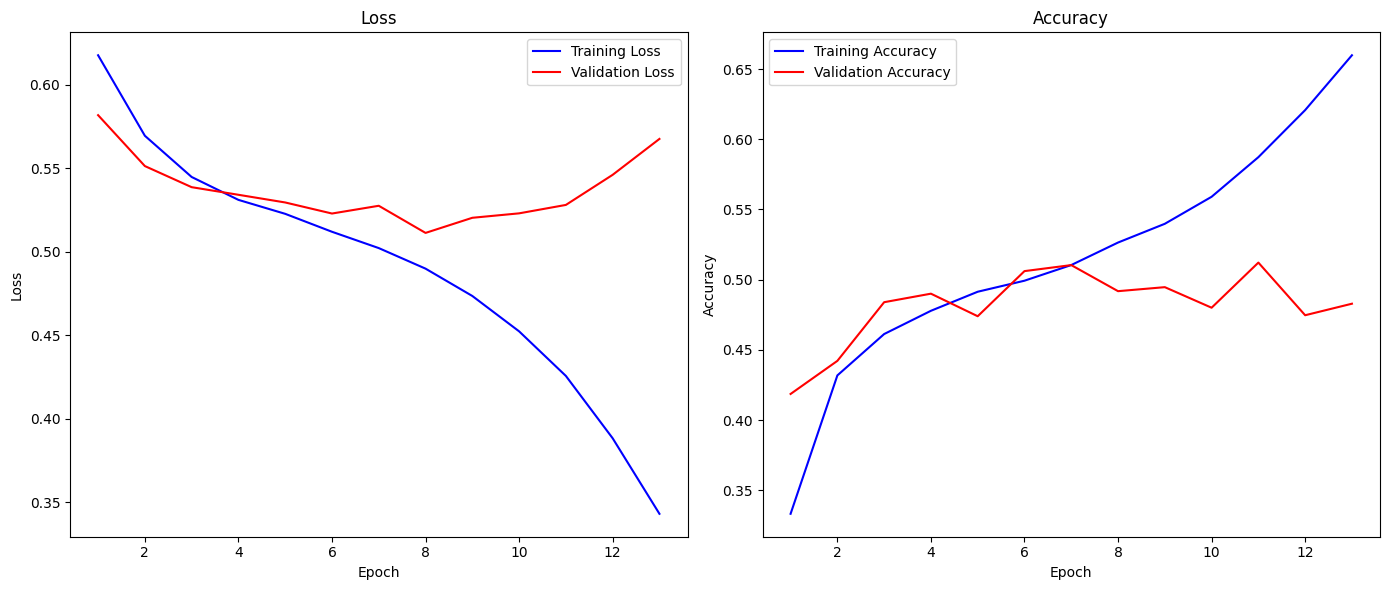

In [98]:
# Plotting the training and validation loss and accuracy
epochs = range(1, len(history_vgg16.history['loss']) + 1)
train_loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']
train_accuracy = history_vgg16.history['accuracy']
val_accuracy = history_vgg16.history['val_accuracy']

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [97]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score

# Load the best models
model_vgg16 = tf.keras.models.load_model('best_model_vgg16.keras')
model_keras_tuned = tf.keras.models.load_model('tuned_model.keras')

# Predict on the test dataset with both models
y_pred_vgg16 = model_vgg16.predict(test_dataset)
y_pred_keras_tuned = model_keras_tuned.predict(test_dataset)

# Ensemble by averaging the predictions
y_pred_ensemble = (y_pred_vgg16 + y_pred_keras_tuned) / 2

# Extract true labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Binarize predictions
y_pred_binary_ensemble = (y_pred_ensemble > 0.3).astype(int)

# Generate classification report
print(classification_report(y_true, y_pred_binary_ensemble, target_names=['No Finding', 'Infiltration', 'Effusion', 'Atelectasis']))

# Calculate AUC-ROC for each class
auc_roc_ensemble = roc_auc_score(y_true, y_pred_ensemble, average=None)
for i, label in enumerate(['No Finding', 'Infiltration', 'Effusion', 'Atelectasis']):
    print(f"{label}: AUC-ROC = {auc_roc_ensemble[i]:.4f}")

# Calculate macro and micro average AUC-ROC
macro_auc_roc_ensemble = roc_auc_score(y_true, y_pred_ensemble, average='macro')
micro_auc_roc_ensemble = roc_auc_score(y_true, y_pred_ensemble, average='micro')
print(f"Macro AUC-ROC: {macro_auc_roc_ensemble:.4f}")
print(f"Micro AUC-ROC: {micro_auc_roc_ensemble:.4f}")

140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

  No Finding       0.48      0.78      0.59       856
Infiltration       0.59      0.84      0.70       853
    Effusion       0.40      0.76      0.53       893
 Atelectasis       0.57      0.82      0.67      1037

   micro avg       0.51      0.80      0.62      3639
   macro avg       0.51      0.80      0.62      3639
weighted avg       0.51      0.80      0.62      3639
 samples avg       0.53      0.78      0.60      3639

No Finding: AUC-ROC = 0.7729
Infiltration: AUC-ROC = 0.8695
Effusion: AUC-ROC = 0.6823
Atelectasis: AUC-ROC = 0.7899
Macro AUC-ROC: 0.7787
Micro AUC-ROC: 0.7896
